## Import Stuff

In [1]:
#IMPORT needed libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import time
import math
import pickle
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import random
%matplotlib inline


In [2]:
#Define function to convert image to gray.
def gray(image):
    grayed_image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    return grayed_image


#Define Line Class
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

## Read in our images

In [3]:
#READ in images from folders
test_images = []
calibration_images = []

for filename in os.listdir("test_images/"):
    filename = "test_images/" + filename
    image = mpimg.imread(filename)
    #print('This image is:', type(image), 'with dimensions:', image.shape, '/n')
    #plt.figure()
    #plt.imshow(image)
    test_images.append(image)

for filename in os.listdir("camera_cal/"):
    filename = "camera_cal/" + filename
    image = mpimg.imread(filename)
    #print('This image is:', type(image), 'with dimensions:', image.shape, '/n')
    #plt.figure()
    #plt.imshow(image)
    calibration_images.append(image)

test_array = np.asarray(test_images)
calibration_array = np.asarray(calibration_images)
#print(calibration_array)

print('The test image array consists of ', test_array.shape[0], ' images with shape ', test_array.shape)
#print('The calibration array consists of ', calibration_array.shape[0], ' images with shape ', calibration_array.shape)


The test image array consists of  8  images with shape  (8, 720, 1280, 3)


## Calibrate camera using the calibration images

In [4]:
#CALIBRATE camera images


criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
undistorted_images = []

for image in calibration_images:
    grayed = gray(image)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(grayed, (9,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(grayed,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(image, (9,6), corners2,ret)
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        #plt.figure()
        #plt.imshow(img)

#CALIBRATE Camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, grayed.shape[::-1],None,None)

for image in calibration_images:
    h,  w = image.shape[:2]
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    # undistort
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    '''
    # crop the image
    x,y,w,h = roi
    dst = dst[y:y+h, x:x+w]
    '''
    #plt.figure()
    #plt.imshow(dst)
    undistorted_images.append(dst)

undistorted_array = np.asarray(undistorted_images)
    
#print('The undistorted image array consists of ', undistorted_array.shape[0], ' images with shape ', undistorted_array.shape[1:3])

#USE pickle to save calibration results
cal_pickle = {}
cal_pickle["mtx"] = mtx
cal_pickle["dist"] = dist
pickle.dump( cal_pickle, open( "calibration.p", "wb"))
print("Wrote Calibration data to calibration.p!")


Wrote Calibration data to calibration.p!


## Example of undistorted calibration image.

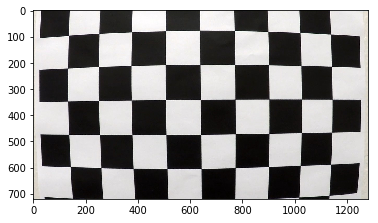

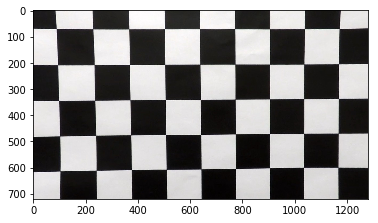

In [5]:
plt.figure()
plt.imshow(calibration_images[0])
plt.figure()
plt.imshow(undistorted_array[0])

The undistorted image array consists of  8  images with shape  (628, 1212)


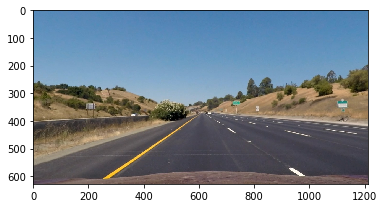

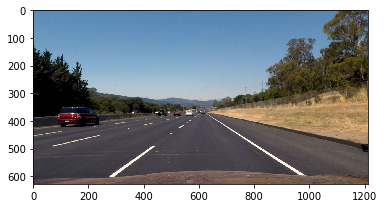

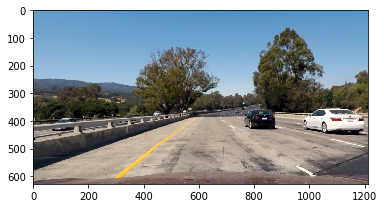

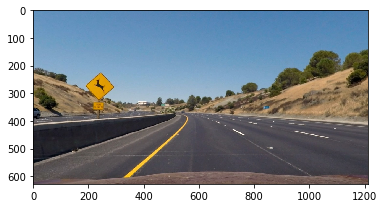

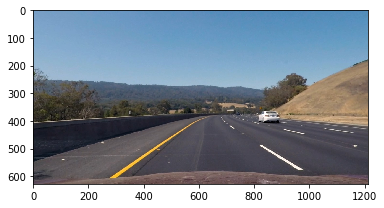

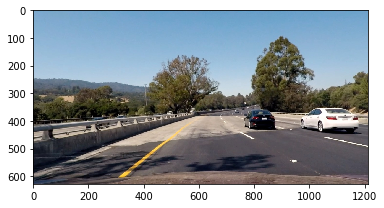

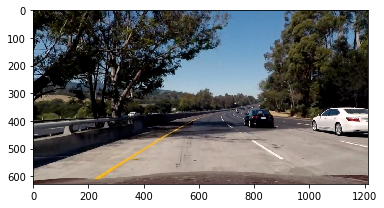

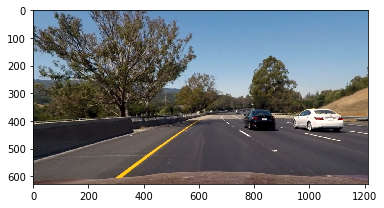

In [6]:
#UNDISTORT test images
undistorted_test_images = []
for image in test_images:
    h,  w = image.shape[:2]
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    # undistort
    dst = cv2.undistort(image, mtx, dist, None, newcameramtx)

    # crop the image
    x,y,w,h = roi
    dst = dst[y:y+h, x:x+w]
    plt.figure()
    plt.imshow(dst)
    undistorted_test_images.append(dst)

undistorted_test_array = np.asarray(undistorted_test_images)
    
print('The undistorted image array consists of ', undistorted_test_array.shape[0], ' images with shape ', undistorted_test_array.shape[1:3])

## Sobel Function

In [7]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

## Magnitude and Direction of Gradient Functions

In [8]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

## Pull S channel from HLS, L from LUV, and B from Lab

In [9]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def luv_select(img, thresh=(0, 255)):
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    l_channel = luv[:,:,0]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output

def lab_select(img, thresh=(0, 255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    b_channel = lab[:,:,2]
    binary_output = np.zeros_like(b_channel)
    binary_output[(b_channel > thresh[0]) & (b_channel <= thresh[1])] = 1
    return binary_output

## Test on an image

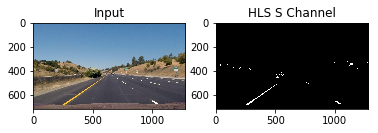

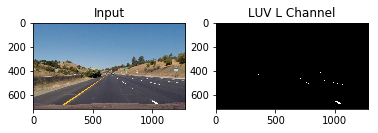

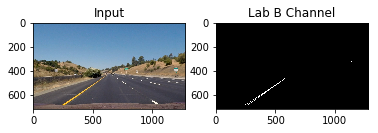

In [10]:
s_channel = hls_select(test_array[0], thresh=(180,255))
plt.subplot(121),plt.imshow(test_array[0]),plt.title('Input')
plt.subplot(122),plt.imshow(s_channel, cmap='gray'),plt.title('HLS S Channel')
plt.show()
l_channel = luv_select(test_array[0], thresh=(220,255))
plt.subplot(121),plt.imshow(test_array[0]),plt.title('Input')
plt.subplot(122),plt.imshow(l_channel, cmap='gray'),plt.title('LUV L Channel')
plt.show()
b_channel = lab_select(test_array[0], thresh=(160,200))
plt.subplot(121),plt.imshow(test_array[0]),plt.title('Input')
plt.subplot(122),plt.imshow(b_channel, cmap='gray'),plt.title('Lab B Channel')
plt.show()

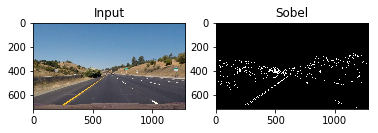

In [11]:
sobel_image = abs_sobel_thresh(test_array[0], orient='x', thresh_min=30, thresh_max=130)
plt.subplot(121),plt.imshow(test_array[0]),plt.title('Input')
plt.subplot(122),plt.imshow(sobel_image, cmap='gray'),plt.title('Sobel')
plt.show()

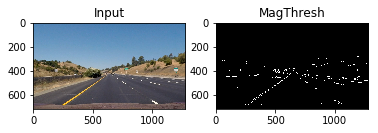

In [12]:
magthresh_image = mag_thresh(test_array[0], sobel_kernel=3, mag_thresh=(75, 255))
plt.subplot(121),plt.imshow(test_array[0]),plt.title('Input')
plt.subplot(122),plt.imshow(magthresh_image, cmap='gray'),plt.title('MagThresh')
plt.show()

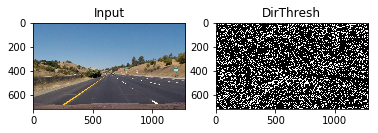

In [13]:
dirthresh_image = dir_threshold(test_array[0], sobel_kernel=3, thresh=(0.65, 1.1))
plt.subplot(121),plt.imshow(test_array[0]),plt.title('Input')
plt.subplot(122),plt.imshow(dirthresh_image, cmap='gray'),plt.title('DirThresh')
plt.show()

## Transform Perspective

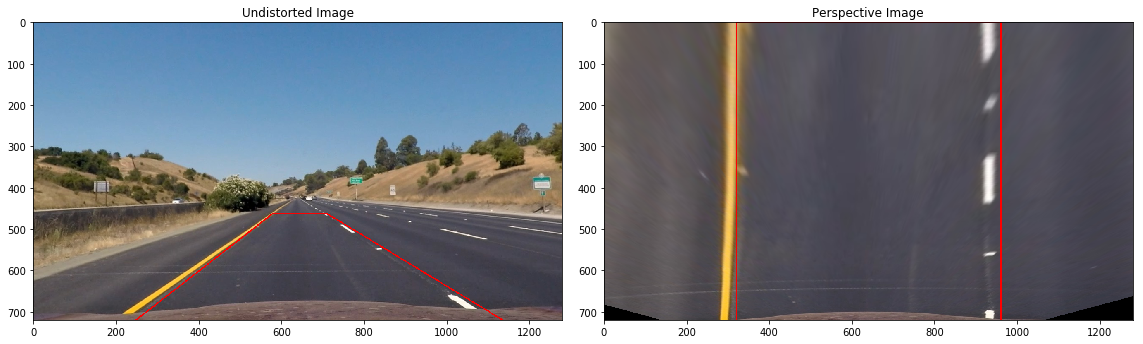

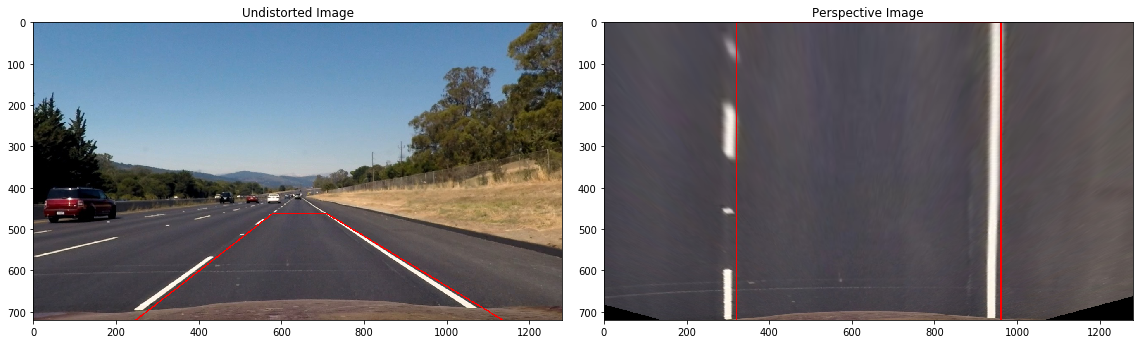

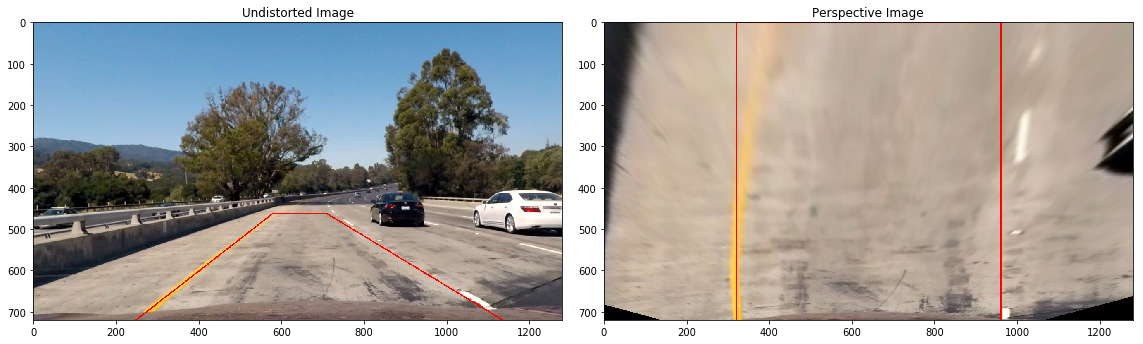

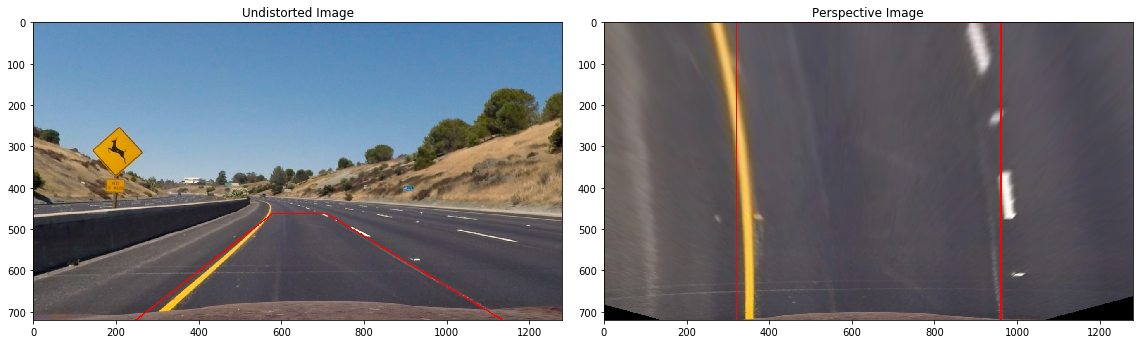

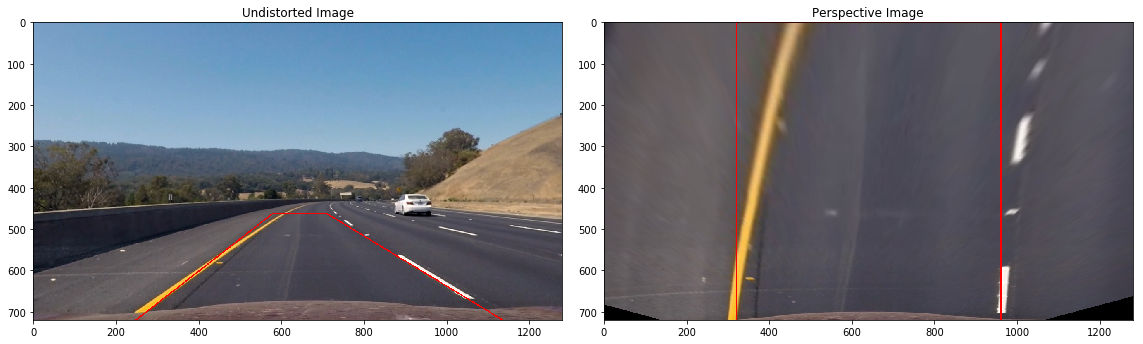

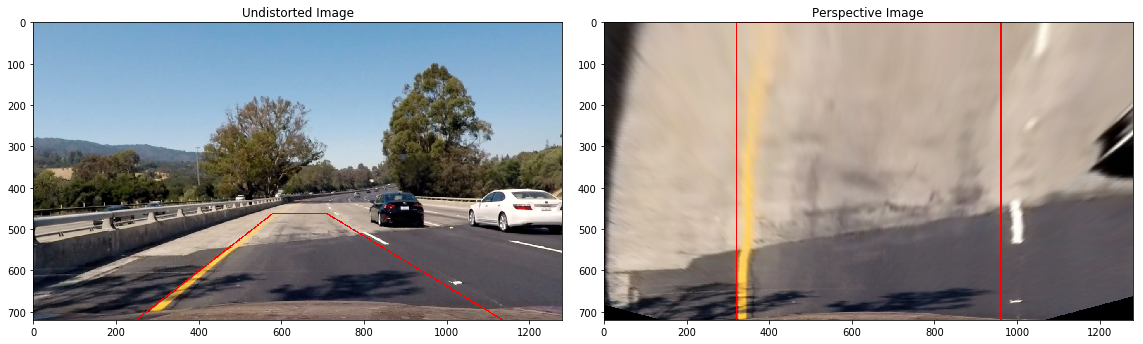

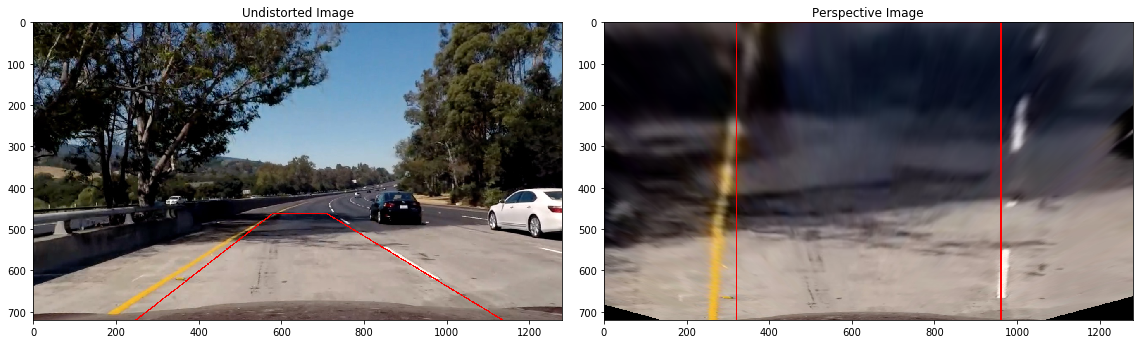

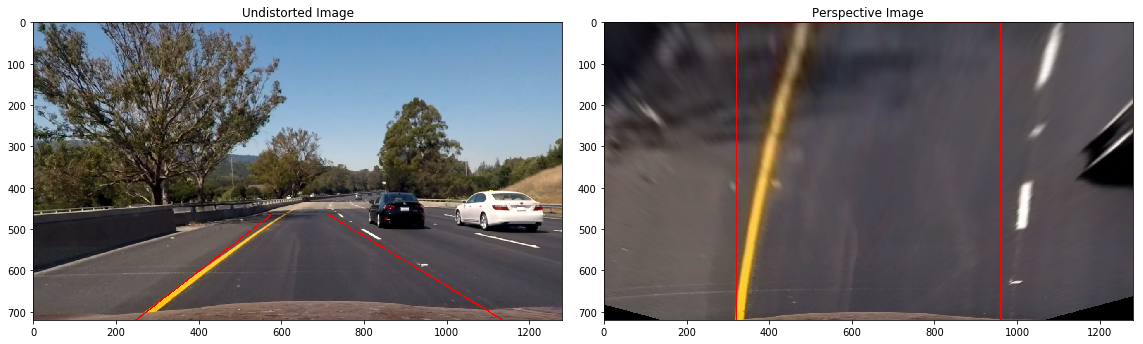

In [76]:
# Define the region

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def perspective_transform(img, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    # For source points I'm grabbing the outer four detected corners
    src = np.float32([[img_size[0] * 0.5 - 60.0, img_size[1] * 0.5 + 102.0],
                    [img_size[0] * 0.17 + 35.0, img_size[1]],
                    [img_size[0] * 0.83  + 75.0, img_size[1]],
                    [img_size[0] * 0.5 + 70.0, img_size[1] * 0.5 + 102.0]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[(img_size[0] * 0.25), 0],
                    [(img_size[0] * 0.25), img_size[1]],
                    [(img_size[0] * 0.75), img_size[1]],
                    [(img_size[0] * 0.75), 0]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    
    Mrev = cv2.getPerspectiveTransform(dst, src)
    return warped, M, Mrev, src, dst
for image in test_array:
    '''undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    perspective_image, perspective_M, perspective_Mrev = perspective_transform(undistorted_image, mtx, dist)
    plt.subplot(121),plt.imshow(undistorted_image),plt.title('Input')
    plt.subplot(122),plt.imshow(perspective_image),plt.title('Perspective Warp')
    plt.show()
    '''
    #PROCESS test_array images
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    perspective_image, perspective_M, perspective_Mrev, src, dst = perspective_transform(undistorted_image, mtx, dist)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    f.tight_layout()
    cv2.polylines(undistorted_image,np.int32([src]),True,(255,0,0),2)
    ax1.imshow(undistorted_image)
    ax1.set_title('Undistorted Image')
    cv2.polylines(perspective_image,np.int32([dst]),True,(255,0,0), 2)
    ax2.imshow(perspective_image)
    ax2.set_title('Perspective Image')


## Find Lane Lines

In [15]:
'''
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin, total_windows):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    lx = []
    ly = []
    rx = []
    ry = []
    
    if 450 < r_center - l_center < 550:
        lx.append(l_center)
        ly.append(image.shape[0])
        rx.append(r_center)
        ry.append(image.shape[0])
    
    
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        if 0 < r_center - l_center < 1000:
            lx.append(l_center)
            ly.append(image.shape[0]-level*image.shape[0]/total_windows)
            rx.append(r_center)
            ry.append(image.shape[0]-level*image.shape[0]/total_windows)
        #print(lx)
    return window_centroids, lx, ly, rx, ry

def sliding_window(warped):
    window_width = 50 
    total_windows = 8
    window_height = warped.shape[0] / total_windows # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching
    window_centroids, lx, ly, rx, ry = find_window_centroids(warped, window_width, window_height, margin, total_windows)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    
    return(output, lx, ly, rx, ry)

'''
def sliding_window(binary_warped):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, out_img



## Functions to draw an image and then write on it
### These ended up being easier to just implement in my pipeline directly

In [60]:
def draw_image(undistorted_image, perspective_image, left_fitx, right_fitx, ploty, perspective_Mrev):
    #print(undistorted_image.shape)
    undistorted_zero = np.zeros_like(undistorted_image).astype(np.uint8)
    undistorted_color = undistorted_zero
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    #print(undistorted_color.shape)
    cv2.fillPoly(undistorted_color, np.int_([pts]), (0, 255, 0))
    new_undistorted = cv2.warpPerspective(undistorted_color, perspective_Mrev, (undistorted_image.shape[1], undistorted_image.shape[0])) 
    result = cv2.addWeighted(undistorted_image, 1, new_undistorted, 0.3, 0)
    # Put text on an image
    #font = cv2.FONT_HERSHEY_SIMPLEX
    #text = "Radius of Curvature: {} m".format(int(curvature))
    #cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
    # Find the position of the car
    #pts = np.argwhere(newwarp[:,:,1])
    #position = find_position(pts)
    #if position < 0:
    #    text = "Vehicle is {:.2f} m left of center".format(-position)
    #else:
    #    text = "Vehicle is {:.2f} m right of center".format(position)
    #cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
    return result
    
def write_on_image(final_image, left_curverad, right_curverad):
    curvature = ((left_curverad + right_curverad) / 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(curvature))
    cv2.putText(final_image,text,(400,100), font, 1,(255,255,255),2)
    return final_image

## Pipeline

In [93]:
def process_image(image):
    #Undistort and warp image into new perspective
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    perspective_image, perspective_M, perspective_Mrev, src, dst = perspective_transform(undistorted_image, mtx, dist)
    #Perform manipulations on new perspective image
    grayed_image = gray(perspective_image)
    gradx = abs_sobel_thresh(perspective_image, orient='x', thresh_min=10 ,thresh_max=230)
    grady = abs_sobel_thresh(perspective_image, orient='y', thresh_min=10 ,thresh_max=230)
    mag_image = mag_thresh(perspective_image, sobel_kernel=3, mag_thresh=(30, 150))
    dir_image = dir_threshold(perspective_image, sobel_kernel=3, thresh=(0.7, 1.3))
    hls_image = hls_select(perspective_image, thresh=(180, 255))
    lab_image = lab_select(perspective_image, thresh=(155, 200))
    luv_image = luv_select(perspective_image, thresh=(225, 255))
    #Thresholding combination
    combined = np.zeros_like(dir_image)
    combined[((gradx == 1) & (hls_image == 1)) | ((mag_image == 1) & (dir_image == 1)) | (lab_image == 1) | (luv_image == 1)] = 1
    left_fit, right_fit, sliding_image = sliding_window(combined)
    ploty = np.linspace(0, combined.shape[0]-1, combined.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    final_image = draw_image(undistorted_image, combined, left_fitx, right_fitx, ploty, perspective_Mrev)
    '''
    #Show lines on combined image for writeup:
    f = plt.figure()
    plt.imshow(combined, cmap='gray')
    plt.plot(left_fitx, ploty, color='blue')
    plt.plot(right_fitx, ploty, color='green')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    '''
    y_eval = np.max(ploty)
    ym_per_pix = 30.0/720.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/700.0 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curvature = ((left_curverad + right_curverad) / 2)
    #print(curvature)
    lane_width = np.absolute(left_fitx[719] - right_fitx[719])
    lane_xm_per_pix = 3.7 / lane_width
    veh_pos = (((left_fitx[719] + right_fitx[719]) * lane_xm_per_pix) / 2)
    cen_pos = ((final_image.shape[1] * lane_xm_per_pix) / 2)
    distance_from_center = abs(veh_pos - cen_pos)
    font = cv2.FONT_HERSHEY_SIMPLEX
    radius_text = "Radius of Curvature: {} m".format(int(curvature))
    cv2.putText(final_image,radius_text,(100,100), font, 1,(255,255,255),2)
    center_text = "Vehicle out of Center by: {} m".format(round(distance_from_center, 3))
    cv2.putText(final_image,center_text,(100,150), font, 1,(255,255,255),2)
    return final_image
    

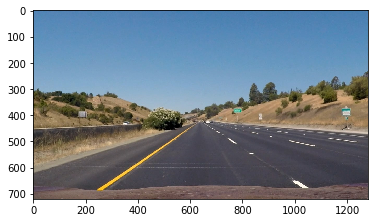

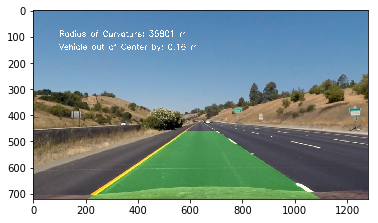

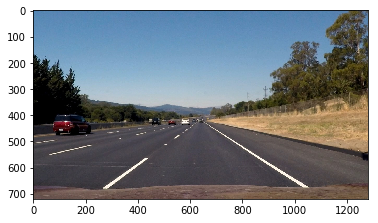

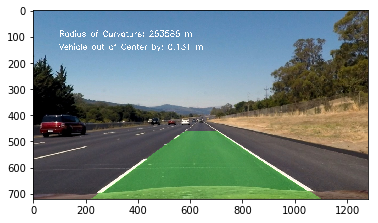

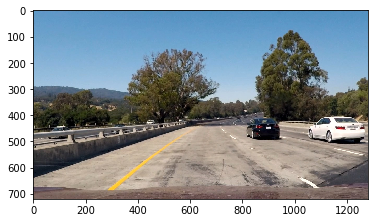

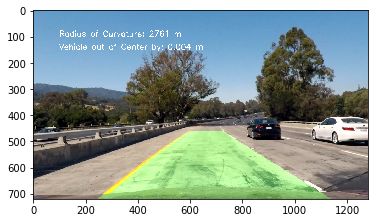

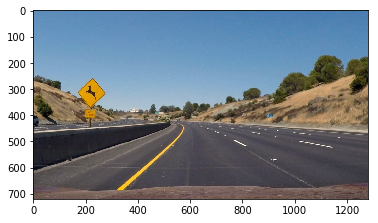

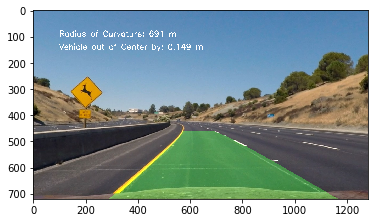

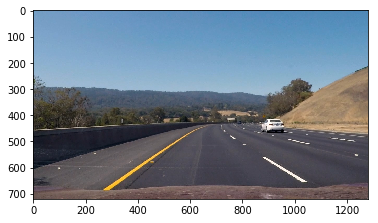

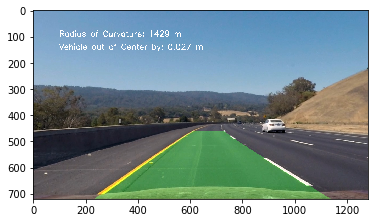

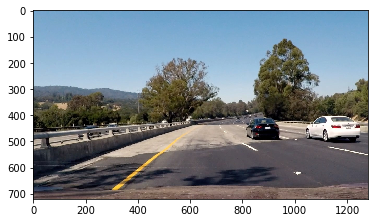

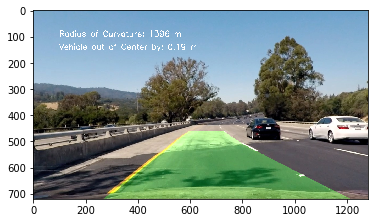

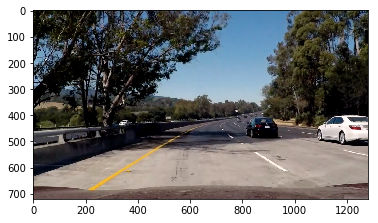

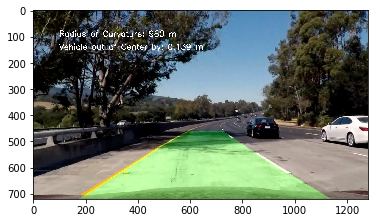

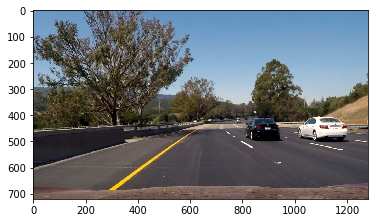

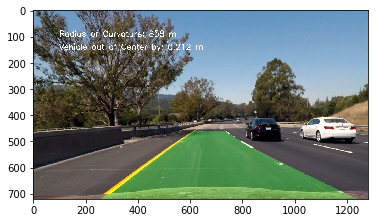

In [94]:
#FOR TEST PURPOSES
for image in test_array:
    processed = process_image(image)
    plt.imshow(image)
    plt.figure()
    #plt.imshow(combined, cmap='gray')
    #plt.figure()
    plt.imshow(processed)
    plt.figure()


## Process project_video.mp4

In [ ]:
project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(project_output, audio=False)

## Process challenge_video.mp4

In [ ]:
project_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(project_output, audio=False)

## Process harder_challenge_video.mp4

In [ ]:
project_output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(project_output, audio=False)